In [1]:
import numpy as np
import mysql.connector
from mysql.connector import Error
import pandas as pd
import datetime
from datetime import date
import time
import matplotlib.pyplot as plt
import seaborn as sns
import smtplib
from email.message import EmailMessage

In [2]:

def createConnection(host_name, user_name, user_password, db_name):
    pw = ''
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

def executeQuery(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

def executeInserts(connection, query, values):
    cursor = connection.cursor()
    try:
        cursor.execute(query, values)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")



def readQuery(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")
        
def emailNotification(subject, body, to):
    msg= EmailMessage()
    msg.set_content(body)
    msg['subject']= subject
    msg['to']= to
    
    user= 'dmacovid@gmail.com'
    msg['from']= user
    password= 'otakkqloodnmtfht'
    
    server= smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(user, password)
    server.send_message(msg)
    print("Email successfully sent")
    server.quit()

In [3]:
subject= 'please get tested'
to= 'rudrathaker26@gmail.com'
body= 'Hello, test msg'
emailNotification(subject, body, to)

Email successfully sent


In [4]:
connection = createConnection("localhost", "root", "" ,'COVIIDdb')

MySQL Database connection successful


In [5]:
testInsert_query = '''INSERT INTO `person` 
(`NUID`,`SSN`,`firstName`,`lastName`,`phoneNo`,`address`,`emailID`,`DOB`,`gender`,`status`) VALUES 
(1111112,1112,"test2","test2","1-111-111-1112","Ap #482-7725 Et, Rd.","test2@test.com","1999-06-27 21:48:54","",1)'''

In [6]:
executeQuery(connection, testInsert_query)

Query successful


In [7]:
query= "SELECT * FROM report"
counts= "SELECT count(result) as counts, date FROM report where result =1 group by date;"
connection = createConnection("localhost", "root", "Passw@rd1996" ,'COVIIDdb')
results= readQuery(connection, query)
counts= readQuery(connection, counts)
resultList = []
for result in results:
    result = list(result)
    resultList.append(result)
    
resultList

coloums = ['reportID', 'sampleID', 'clinicID', 'date', 'result']
df_reports = pd.DataFrame(resultList, columns=coloums)


df_reports['date'] = pd.to_datetime(df_reports['date'], format= '%m/%d/%y')
df_reports

MySQL Database connection successful


,reportID,sampleID,clinicID,date,result
0,1,16385,1,2021-03-04,0
1,2,16386,1,2021-03-04,0
2,3,16387,1,2021-03-04,0
3,4,16388,1,2021-03-04,0
4,5,16389,1,2021-03-04,0
...,...,...,...,...,...
148,149,16482,2,2021-03-18,0
149,150,16483,2,2021-03-18,0
150,151,16484,2,2021-03-19,0
151,164,16485,1,2021-06-10,1


In [8]:
countList= []
for count in counts:
    count = list(count)
    countList.append(count)
    
countList

coloumns = ['counts', 'date']
df_counts = pd.DataFrame(countList, columns=coloumns)

df_counts['date'] = pd.to_datetime(df_counts['date'], format= '%m/%d/%y')
df_counts.counts=df_counts.counts.astype(np.float64)
df_counts

,counts,date
0,2.0,2021-03-05
1,1.0,2021-03-08
2,1.0,2021-03-11
3,1.0,2021-03-12
4,1.0,2021-03-14
5,1.0,2021-03-16
6,1.0,2021-03-17
7,1.0,2021-06-10


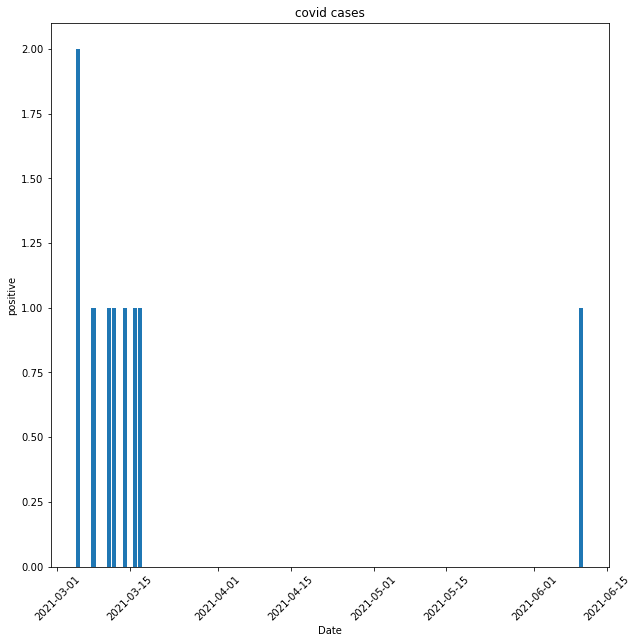

In [9]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.bar(df_counts.date.values,
        df_counts.counts)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="positive",
       title="covid cases")

# Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

# Notification to positive patients

In [10]:
query_emails= '''SELECT p.emailID FROM person p
	JOIN testAppointment ta ON (p.NUID = ta.NUID)
    JOIN testEvent te ON (ta.appointmentID = te.appointmentID)
    JOIN report r ON (te.eventID = r.sampleID) where r.result = 1;'''

subject1= 'COVID POSITIVE'

body1= 'You have been tested Positive for Covid-19, Please report to th University for quarantine advices.'

emails = readQuery(connection, query_emails)
for email in emails:
#       print(email)
     emailNotification(subject1, body1, to = email)
print("Emails successfullt sent")

Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Emails successfullt sent


# Notification to book test appointment

In [11]:
query_remind_test = '''SELECT r.result, r.date AS resultDate, t.date AS appointmentDate, p.emailID from report r JOIN testEvent te 
	ON (r.sampleID = te.eventID) JOIN testAppointment t 
    ON (te.appointmentID = t.appointmentID) JOIN person p 
    ON (t.NUID = p.NUID) WHERE r.result = 0;'''
remind_test = readQuery(connection, query_remind_test)

In [12]:
columns = ['result', 'resultDate', 'appointmentDate', 'emailID']
df_remind_test = pd.DataFrame(remind_test, columns=columns)
df_remind_test['resultDate'] = pd.to_datetime(df_remind_test['resultDate'], format= '%m/%d/%y')
df_remind_test['appointmentDate'] = pd.to_datetime(df_remind_test['appointmentDate'], format= '%m/%d/%y')
df_remind_test

,result,resultDate,appointmentDate,emailID
0,0,2021-03-04,2021-03-01,pede@in.net
1,0,2021-03-04,2021-03-02,Aliquam.erat.volutpat@porttitor.com
2,0,2021-03-04,2021-03-03,consequat.dolor@purus.com
3,0,2021-03-04,2021-03-04,amet@sitametconsectetuer.org
4,0,2021-03-04,2021-03-05,tellus.non.magna@ultriciesligula.co.uk
...,...,...,...,...
139,0,2021-03-18,2021-06-05,purus@tinciduntnuncac.org
140,0,2021-03-18,2021-06-06,Nulla.tincidunt.neque@ametmassa.edu
141,0,2021-03-18,2021-06-07,Pellentesque.habitant@Fusce.org
142,0,2021-03-19,2021-06-08,adipiscing.elit@orciUtsemper.co.uk


In [14]:
Subject2= "Time to book your next Test"
body2= "Please book your next covid test in order be complient"
numdays = datetime.timedelta(days=3)
df_emailID_remind=  df_remind_test[((datetime.datetime.now())-(df_remind_test.appointmentDate) >= numdays)].emailID
count_emails=[]
for e_mails in df_emailID_remind:
#      print(e_mails)
     emailNotification(Subject2, body2, to=e_mails)

Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successful

# Second dose notification

In [15]:
vaccine_dose = '''SELECT p.emailID FROM vaccineForm vf JOIN person p ON (vf.NUID = p.NUID) where vf.dose=1;'''
vaccine_notifacation = readQuery(connection, vaccine_dose)

In [16]:
Subject3= "Second Dose appointment"
body3= "Please Book your Second dose appointment"
for dose in vaccine_notifacation:
#      print(dose)
    emailNotification(Subject3, body3, to=dose)

Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
Email successfully sent
